# 现代CNN
## 知识点
- 现代CNN的例子
- AlexNet
  - 传统机器学习pipeline（非end-to-end）：
    - 通过传感器收集数据集
    - 手工对数据集进行预处理
    - 通过SIFT/HOG/SURF等特征提取算法，或其他手动设计的流程，来处理数据
    - 将提取的特征输入分类器（基于凸优化的传统方法，如线性模型或核方法）中训练
  - 使用了dropout、大量的图像增强
- VGG
  - 模块化的尝试：寻找重复模式，神经元 -> 层 -> 块
- NiN
  - 卷积层 输入和输出：四维张量，样本x通道x高度x宽度
  - 全连接层 输入和输出：二为张量，样本x特征
  - NiN将每个像素视为样本，将通道维度视为特征，因而使用1x1卷积
  - 没有全连接层
    - 使用NiN块，输出通道数等于标签
    - 最后是一个全局平均pooling层，生成logits
- GoogLeNet
  - 含并行连接的网络，有四条通道
  - 基本卷积块：Inception Block
- ResNet
  - 嵌套函数层的思想
- DenseNet
  - ResNet的输出是两项相加，将函数展开为`一个简单线性项`和`一个复杂非线性项` $$f(x) = x + g(x)$$
  - DenseNet的输出是连接，将函数展开为 $$ x \rightarrow [x, f_1(x), f_2([x, f_1(x)]), f_3([x, f_1(x), f_2([x, f_1(x)])])]$$
  - DenseNet由两部分构成：`稠密块`和`过渡层`




---

In [ ]:
import torch
from torch import nn
from d2l import torch as d2l

'''根据AlexNet的图示'''
net = nn.Sequential(
    nn.Conv2d(1, 96, kernel_size=11, stride=4, padding=1), nn.ReLU(), # 54*54
    nn.MaxPool2d(kernel_size=3, stride=2), # 26*26
    nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(), # 26*26
    nn.MaxPool2d(kernel_size=3, stride=2), # 12*12
    nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(), # 12*12
    nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(), # 12*12
    nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(), # 12*12
    nn.MaxPool2d(kernel_size=3, stride=2), # 5*5
    nn.Flatten(),
    # 全连接层输出数量很多，使用Dropout层来减轻overfit
    nn.Linear(6400, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 4096), nn.ReLU(),
    nn.Dropout(p=0.5),
    nn.Linear(4096, 10) # 使用Fashion-MNIST，因此改为十分类
)

In [ ]:
X = torch.randn(1, 1, 224, 224)
for layer in net:
    X = layer(X)
    print(layer._get_name(), 'output shape:\t', X.shape)

Conv2d output shape:	 torch.Size([1, 96, 54, 54])
ReLU output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Conv2d output shape:	 torch.Size([1, 256, 26, 26])
ReLU output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 384, 12, 12])
ReLU output shape:	 torch.Size([1, 384, 12, 12])
Conv2d output shape:	 torch.Size([1, 256, 12, 12])
ReLU output shape:	 torch.Size([1, 256, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 256, 5, 5])
Flatten output shape:	 torch.Size([1, 6400])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1,

loss 0.326, train acc 0.880, test acc 0.880
6342.5 examples/sec on cuda


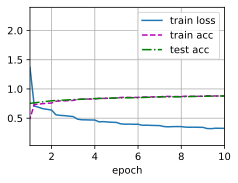

In [ ]:
batch_size = 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)

lr, num_epochs = 0.01, 10
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, device)

In [ ]:
'''实现一个视觉几何组（VGG）块'''
import torch
from torch import nn
from d2l import torch as d2l

def vgg_block(num_convs, in_channels, out_channels):
    layers = []
    for _ in range(num_convs):
        layers.append(nn.Conv2d(in_channels, out_channels,
                                kernel_size=3, padding=1))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
    return nn.Sequential(*layers) # 使用*解包

In [ ]:
# 参数：卷积层数目、输出通道数量
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

def vgg(conv_arch):
    '''实现VGG-11'''
    conv_blks = []
    in_channels = 1
    # 卷积层部分
    for(num_convs, out_channels) in conv_arch:
        conv_blks.append(vgg_block(num_convs, in_channels, out_channels))
        in_channels = out_channels

    return nn.Sequential(
        *conv_blks, nn.Flatten(), #VGG块
        nn.Linear(out_channels * 7 * 7, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 10)
    )

net = vgg(conv_arch)

In [ ]:
X = torch.rand(1, 1, 224, 224)
for blk in net:
    X = blk(X)
    print(blk._get_name(), 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


loss 0.171, train acc 0.938, test acc 0.923
3688.6 examples/sec on cuda:0


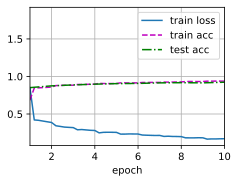

In [ ]:
ratio = 4
# 为了加快训练速度，通道数量缩放为原本的1/4
small_conv_arch = [
    (pair[0], pair[1] // ratio) for pair in conv_arch
]
net = vgg(small_conv_arch)

lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
'''NiN块'''
import torch
from torch import nn
from d2l import torch as d2l

def nin_blocks(in_channels, out_channels, kernel_size, strides, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, strides, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size=1), nn.ReLU()
    )

In [ ]:
net = nn.Sequential(
    nin_blocks(1, 96, kernel_size=11, strides=4, padding=0),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_blocks(96, 256, kernel_size=5, strides=1, padding=2),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nin_blocks(256, 384, kernel_size=3, strides=1, padding=1),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Dropout(0.5),
    # 0-9 十分类问题
    nin_blocks(384, 10, kernel_size=3, strides=1, padding=1),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Flatten()
)

In [ ]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer._get_name(),'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 96, 54, 54])
MaxPool2d output shape:	 torch.Size([1, 96, 26, 26])
Sequential output shape:	 torch.Size([1, 256, 26, 26])
MaxPool2d output shape:	 torch.Size([1, 256, 12, 12])
Sequential output shape:	 torch.Size([1, 384, 12, 12])
MaxPool2d output shape:	 torch.Size([1, 384, 5, 5])
Dropout output shape:	 torch.Size([1, 384, 5, 5])
Sequential output shape:	 torch.Size([1, 10, 5, 5])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 10, 1, 1])
Flatten output shape:	 torch.Size([1, 10])


loss 0.352, train acc 0.867, test acc 0.868
5302.8 examples/sec on cuda:0


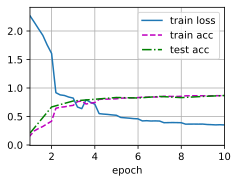

In [ ]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=224)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [1]:
'''Inception块有四条并行通道，综合考虑不同卷积模式的效果'''
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Inception(nn.Module):
    def __init__(self, in_channels, c1, c2, c3, c4, **kwargs):
        super(Inception, self).__init__(**kwargs)
        # channel 1
        self.p1_1 = nn.Conv2d(in_channels, c1, kernel_size=1)
        # channel 2
        self.p2_1 = nn.Conv2d(in_channels, c2[0], kernel_size=1)
        self.p2_2 = nn.Conv2d(c2[0], c2[1], kernel_size=3, padding=1)
        # channel 3
        self.p3_1 = nn.Conv2d(in_channels, c3[0], kernel_size=1)
        self.p3_2 = nn.Conv2d(c3[0], c3[1], kernel_size=5, padding=2)
        # channel 4
        self.p4_1 = nn.MaxPool2d(kernel_size=3, stride=1, padding=1)
        self.p4_2 = nn.Conv2d(in_channels, c4, kernel_size=1)

    def forward(self, x):
        p1 = F.relu(self.p1_1(x))
        p2 = F.relu(self.p2_2(F.relu(self.p2_1(x))))
        p3 = F.relu(self.p3_2(F.relu(self.p3_1(x))))
        p4 = F.relu(self.p4_2(self.p4_1(x)))
        # 在通道维度上连接，输出
        return torch.cat((p1, p2, p3, p4), dim=1)


In [2]:
b1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b2 = nn.Sequential(nn.Conv2d(64, 64, kernel_size=1),
                   nn.ReLU(),
                   nn.Conv2d(64, 192, kernel_size=3, padding=1),
                   nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b3 = nn.Sequential(Inception(192, 64, (96, 128), (16, 32), 32),
                   Inception(256, 128, (128, 192), (32, 96), 64),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))


b4 = nn.Sequential(Inception(480, 192, (96, 208), (16, 48), 64),
                   Inception(512, 160, (112, 224), (24, 64), 64),
                   Inception(512, 128, (128, 256), (24, 64), 64),
                   Inception(512, 112, (144, 288), (32, 64), 64),
                   Inception(528, 256, (160, 320), (32, 128), 128),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

b5 = nn.Sequential(Inception(832, 256, (160, 320), (32, 128), 128),
                   Inception(832, 384, (192, 384), (48, 128), 128),
                   nn.AdaptiveAvgPool2d((1,1)), # 实现全局平均pooling层
                   nn.Flatten())

net = nn.Sequential(b1, b2, b3, b4, b5, nn.Linear(1024, 10))

In [3]:
X = torch.rand(size=(1, 1, 96, 96))
for layer in net:
    X = layer(X)
    print(layer._get_name(), 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 24, 24])
Sequential output shape:	 torch.Size([1, 192, 12, 12])
Sequential output shape:	 torch.Size([1, 480, 6, 6])
Sequential output shape:	 torch.Size([1, 832, 3, 3])
Sequential output shape:	 torch.Size([1, 1024])
Linear output shape:	 torch.Size([1, 10])


loss 0.239, train acc 0.910, test acc 0.878
3459.3 examples/sec on cuda:0


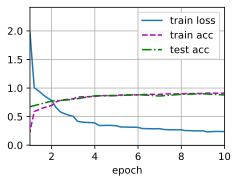

In [4]:
lr, num_epochs, batch_size = 0.1, 10, 128
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [12]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
  def __init__(self, input_channels, num_channels,
              use_1x1conv=False, strides=1):
    super().__init__()
    self.conv1 = nn.Conv2d(input_channels, num_channels,
                          kernel_size=3, padding=1, stride=strides)
    self.conv2 = nn.Conv2d(num_channels, num_channels,
                          kernel_size=3, padding=1) # 步长默认为1
    if use_1x1conv: # 可选使用1x1卷积层
      self.conv3 = nn.Conv2d(input_channels, num_channels,
                              kernel_size=1, stride=strides)
    else:
      self.conv3 = None
    # 批量正则化层
    self.bn1 = nn.BatchNorm2d(num_channels)
    self.bn2 = nn.BatchNorm2d(num_channels)

  def forward(self, X):
    Y = F.relu(self.bn1(self.conv1(X)))
    Y = self.bn2(self.conv2(Y))
    if self.conv3:
      X = self.conv3(X)
    # 残差和
    Y += X
    return F.relu(Y)

In [7]:
blk = Residual(3, 3) # input_channels, num_channels
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [8]:
blk = Residual(3, 6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

In [10]:
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

def resnet_block(input_channels, num_channels, num_residuals, 
                 first_block=False): # 对第一个块特别处理
    blk = []
    # 每个模块使用num_residuals个同样输出通道的Residual块
    for i in range(num_residuals):
        if i == 0 and not first_block:
            blk.append(Residual(input_channels, num_channels,
                                use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    return blk

# 在ResNet中加入残差块
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

'''利用上述模块搭建ResNet-18'''
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)), # 和GoogLeNet一样过一个全局平均汇聚层
                    nn.Flatten(),
                    nn.Linear(512, 10))

X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer._get_name(), 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


loss 0.010, train acc 0.998, test acc 0.922
3201.0 examples/sec on cuda:0


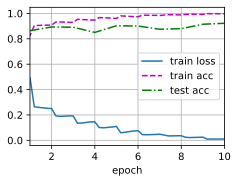

In [13]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [14]:
'''DenseNet - 将函数展开为多个部分'''
import torch
from torch import nn
from d2l import torch as d2l

def conv_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1)
    )

class DenseBlock(nn.Module):
    def __init__(self, num_convs, input_channels, num_channels):
        super().__init__()
        layer = []
        for i in range(num_convs):
            '''
            每个conv_block的输入不仅包括DenseBlock的原始输入，
            还包括所有之前conv_block的输出
            这就是“密集连接”的含义：每层的输出都会被用作之后所有层的输入。
            '''
            layer.append(conv_block(
                num_channels * i + input_channels, num_channels
            ))
        self.net = nn.Sequential(*layer)
    
    def forward(self, X):
        for blk in self.net:
            Y = blk(X)
            # 连接通道维度(dim=1)上每个块的输入和输出
            X = torch.cat((X, Y), dim=1)
        return X
        

In [15]:
blk = DenseBlock(2, 3, 10)
X = torch.randn(4, 3, 8, 8)
Y = blk(X)
Y.shape

torch.Size([4, 23, 8, 8])

In [23]:
'''每经过一个稠密块就会带来通道数的增加，因此使用过渡层来减少通道数'''
def transition_block(input_channels, num_channels):
    return nn.Sequential(
        nn.BatchNorm2d(input_channels), nn.ReLU(),
        nn.Conv2d(input_channels, num_channels, kernel_size=1), # 1x1对通道层卷积
        nn.AvgPool2d(kernel_size=2, stride=2)
    )

blk = transition_block(23, 10)
blk(Y).shape

torch.Size([4, 10, 4, 4])

loss 0.144, train acc 0.948, test acc 0.833
2888.1 examples/sec on cuda:0


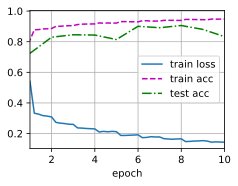

In [26]:
'''DenseNet模型'''

# 单卷积层、最大汇聚层
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
    nn.BatchNorm2d(64), nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
)

# 使用4个Dense块
num_channels, growth_rate = 64, 32  # 增长率指dense块里卷积层通道数，每个块使用4个卷积层所以将总共增加128个通道
num_conv_in_dense_blocks = [4, 4, 4, 4]
blks = []
for i, num_convs in enumerate(num_conv_in_dense_blocks):
    blks.append(DenseBlock(num_convs, num_channels, growth_rate))
    # 上一个Dense块的输出通道数
    num_channels += num_convs * growth_rate
    # 在Dense块之间加一个转换层，使通道数减半
    if i != len(num_conv_in_dense_blocks) - 1:
        blks.append(transition_block(num_channels, num_channels // 2))
        num_channels = num_channels // 2

net = nn.Sequential(
    b1, 
    *blks,
    nn.BatchNorm2d(num_channels), nn.ReLU(),
    nn.AdaptiveAvgPool2d((1, 1)), # GAP
    nn.Flatten(),
    nn.Linear(num_channels, 10)
)

lr, num_epochs, batch_size = 0.1, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)  # 输入高和宽简化为96
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())